In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import h5py
import sys

sys.path.append('../')

from cnn.commons import show_images, ft_train_model, visualize_model, save_dict_to_hdf5

plt.ion()   # interactive mode

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
torch.manual_seed(78)
np.random.seed(78)

data_dir = '../data/chest_xray'

In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                        shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

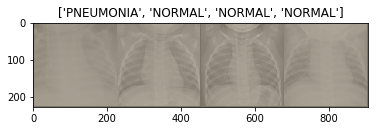

In [14]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

show_images(out, title=[class_names[x] for x in classes])

### VGG16

In [15]:
model_ft = models.vgg16(pretrained=True)
model_ft = model_ft.eval()
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier[-1].in_features
temp = list(model_ft.classifier.children())[:-1]
temp.append(nn.Linear(num_ftrs, 2))
model_ft.classifier = nn.Sequential(*temp)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.classifier[-1].parameters(), lr=1e-3)

### ResNet18

In [6]:
model_ft = models.resnet18(pretrained=True)
model_ft = model_ft.eval()
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=1e-3)

In [16]:
model_ft = ft_train_model(model_ft, criterion, optimizer_ft, dataloaders, device,
                          dataset_sizes, class_names, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.2086 Acc: 0.9184
test Loss: 0.6473 Acc: 0.8061

Epoch 1/1
----------
train Loss: 0.2021 Acc: 0.9268
test Loss: 0.7477 Acc: 0.8013

Training complete in 1m 37s
Best test Acc: 0.806090


In [18]:
visualize_model(model_ft, dataloaders, class_names, device, num_images=2)

TypeError: visualize_model() got multiple values for keyword argument 'num_images'

In [ ]:
weight_dict = {'fl_W:0' : model_ft.state_dict()['classifier.6.weight'].cpu().data.numpy(),
               'fl_b:0' : model_ft.state_dict()['classifier.6.bias'].cpu().data.numpy()}

save_dict_to_hdf5(weight_dict, 'chest_xray_vgg16_fl.ptch')